# Format pyramidal cell spike data

author: steeve.laquitaine@epfl.ch

* input instances: a 2D matrix of waveform x timepoints (x unit x channels) stacked vertically.
* labels: a vector of unit ids

In [1]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy


# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(PROJ_PATH)
from src.nodes.prepro import preprocess
from src.nodes.postpro import waveform
from src.nodes.utils import get_config
from src.nodes.truth.silico import ground_truth
from src.nodes.io.silico.loading import load_campaign_params
from src.nodes.dataeng.deepnet.dataeng import get_instances
from src.nodes.prepro import probe_wiring
from src.nodes.dataeng.silico.filtering import filter_microcircuit_cells
from src.nodes import viz

# SET DATA PATH 
# whole campaign files
SPIKE_FILE_PATH = "/gpfs/bbp.cscs.ch/data/scratch/proj68/laquitai/dataeng/0_silico/Hex0_4s_reyes128/campaign/raw/spiketrains.pkl"
RAW_LFP_TRACE_FILE_PATH = "/gpfs/bbp.cscs.ch/data/scratch/proj68/laquitai/dataeng/0_silico/Hex0_4s_reyes128/campaign/raw/traces.pkl"
CELL_TRACE_FILE_PATH = "/gpfs/bbp.cscs.ch/data/scratch/proj68/laquitai/dataeng/0_silico/Hex0_4s_reyes128/campaign/raw/cells/cell_3754013_trace.pkl"


# SET PARAMETERS
SIMULATION_DATE = "2023_01_13"
STUDY_FOLDER = '/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/output/0_silico/Hex0_4s_reyes128/Hex0_4s_reyes128_study'
EXAMPLE_CELL_ID = 3754013
EXAMPLE_CHANNEL_ID = 71
MS_BEFORE = 3           # ms
MS_AFTER = 3            # ms
CELL_TYPE = "PYR"

# SET CONFIG
data_conf, param_conf = get_config(SIMULATION_DATE).values()


# SET MODEL INPUT DATA PATHS
INSTANCE_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["instances"]
CHANNEL_IDS_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["channel_ids"]
CELL_LABELS_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["cell_labels"]
SPIKE_STATUS_FILE_PATH = data_conf["sorting"]["deepnet"]["input"]["spike_status"]
NEAREST_CHANNEL_FILE_PATH  = data_conf["sorting"]["deepnet"]["input"]["nearest_channel"]

2023-02-01 09:46:18,425 - root - utils.py - get_config - INFO - Loaded config


Extract all cell spike waveforms

In [2]:
# Preprocess traces and extract waveforms (3 min, a 40 secs campaign, 1000ish cells)
WaveformExtractor = waveform.run_from_files(simulation_date=SIMULATION_DATE,
    lfp_trace_file=RAW_LFP_TRACE_FILE_PATH,
    spike_file=SPIKE_FILE_PATH,
    study_folder=STUDY_FOLDER,
    ms_before=MS_BEFORE,
    ms_after=MS_AFTER
    )

2023-02-01 09:46:26,647 - root - utils.py - get_config - INFO - Loaded config
2023-02-01 09:46:38,864 - root - loading.py - load_campaign_params - INFO - Channel locations have been written in file: /gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/channel_locations/
2023-02-01 09:48:13,283 - root - loading.py - load_campaign_params - INFO - Channel locations have been written in file: /gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/channel_locations/
write_binary_recording with n_jobs = 1 and chunk_size = None
write_binary_recording with n_jobs = 1 and chunk_size = None


Query near-probe pyramidal cells

In [3]:
# filter all near-contact pyramidal cells (1090 cells)
simulation = load_campaign_params(data_conf, param_conf)
Truth = ground_truth.run(simulation, data_conf, param_conf)["ground_truth_sorting_object"]
cell_morph = simulation["circuit"].cells.get(Truth.unit_ids, properties=['morph_class'])
CELL_IDS = cell_morph[cell_morph["morph_class"] == CELL_TYPE].index.values

2023-02-01 09:50:12,295 - root - loading.py - load_campaign_params - INFO - Channel locations have been written in file: /gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/channel_locations/


Format selected cells' spike data instances and labels

In [4]:
# format spike instances for DEEPNET model (30 secs)
out = get_instances(WaveformExtractor, cell_ids=CELL_IDS)
spike_instances = out["instances"]
spike_channel_ids = out["channel_ids"]
spike_cell_labels = out["cell_labels"]
spike_status = np.repeat(1,len(out["instances"]))

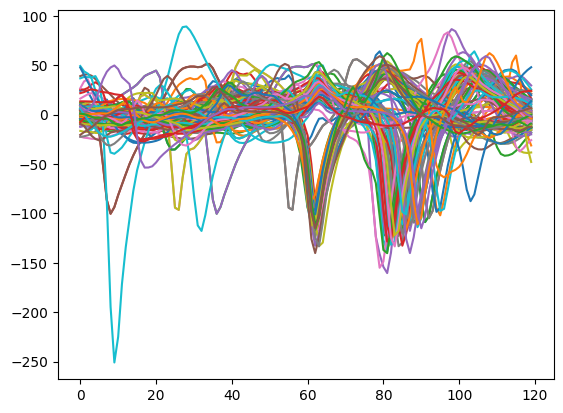

In [6]:
# check plot
plt.plot(spike_instances[np.logical_and(spike_cell_labels==EXAMPLE_CELL_ID, spike_channel_ids==EXAMPLE_CHANNEL_ID), :].T);

Extract non-spike data

- for now take data before each cell's first spike

In [7]:
# get cells' spikes
spike_ms = pd.read_pickle(SPIKE_FILE_PATH)

# get each cell's first spike 
u, indices = np.unique(spike_ms, return_index=True)

# set a no-spike timestamp 10 ms before each cell's first spike
non_spikes = spike_ms.iloc[indices].sort_index() 
non_spikes.index = non_spikes.index - 10

In [8]:
# Preprocess and extract non-spike signals (1 min)
NonWaveformExtractor = waveform.run(simulation_date=SIMULATION_DATE,
    lfp_trace_file=RAW_LFP_TRACE_FILE_PATH,
    spike_ms=non_spikes,
    study_folder=STUDY_FOLDER,
    ms_before=MS_BEFORE,
    ms_after=MS_AFTER
    )

2023-02-01 09:54:21,970 - root - utils.py - get_config - INFO - Loaded config
2023-02-01 09:54:31,909 - root - loading.py - load_campaign_params - INFO - Channel locations have been written in file: /gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/channel_locations/
2023-02-01 09:54:44,878 - root - loading.py - load_campaign_params - INFO - Channel locations have been written in file: /gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/channel_locations/
write_binary_recording with n_jobs = 1 and chunk_size = None
write_binary_recording with n_jobs = 1 and chunk_size = None


In [9]:
# format non-spike instances for DEEPNET model
out = get_instances(NonWaveformExtractor, cell_ids = CELL_IDS)
non_spike_instances = out["instances"]
non_spike_channel_ids = out["channel_ids"]
non_spike_cell_labels = out["cell_labels"]
non_spike_status = np.repeat(0,len(out["instances"]))

Concatenate spike and non-spike signals

In [10]:
# stack
instances = np.vstack([spike_instances, non_spike_instances])
channel_ids = np.hstack([spike_channel_ids, non_spike_channel_ids])
cell_labels = np.hstack([spike_cell_labels, non_spike_cell_labels])
spike_status = np.hstack([spike_status, non_spike_status])

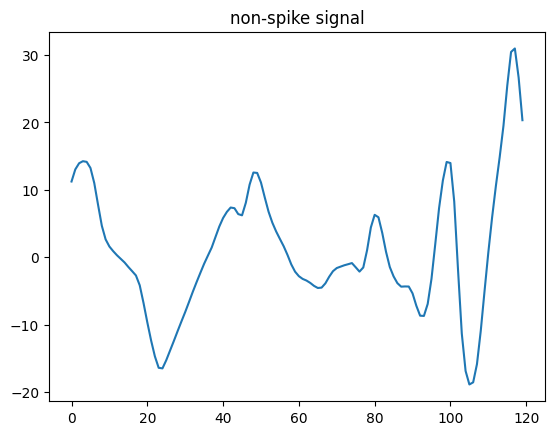

In [13]:
# check plot
plt.plot(non_spike_instances[np.logical_and(non_spike_cell_labels==EXAMPLE_CELL_ID, non_spike_channel_ids==EXAMPLE_CHANNEL_ID), :].T);
plt.title("non-spike signal");

### Label spike instances with their nearest channel contact

In [15]:
# cell coordinates
cell_true_coord = simulation["circuit"].cells.get(CELL_IDS, properties=["x","y","z"])

# preprocess recording
recording = preprocess.run(data_conf, param_conf)

# wire probe
recording = probe_wiring.run(data_conf, param_conf)

# get probe coordinates
probe = recording.get_probe()
channel_coord = probe.contact_positions

2023-02-01 09:59:21,201 - root - loading.py - load_campaign_params - INFO - Channel locations have been written in file: /gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/channel_locations/
write_binary_recording with n_jobs = 1 and chunk_size = None
2023-02-01 09:59:51,578 - root - loading.py - load_campaign_params - INFO - Channel locations have been written in file: /gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/Hex0_4s_reyes128/channel_locations/


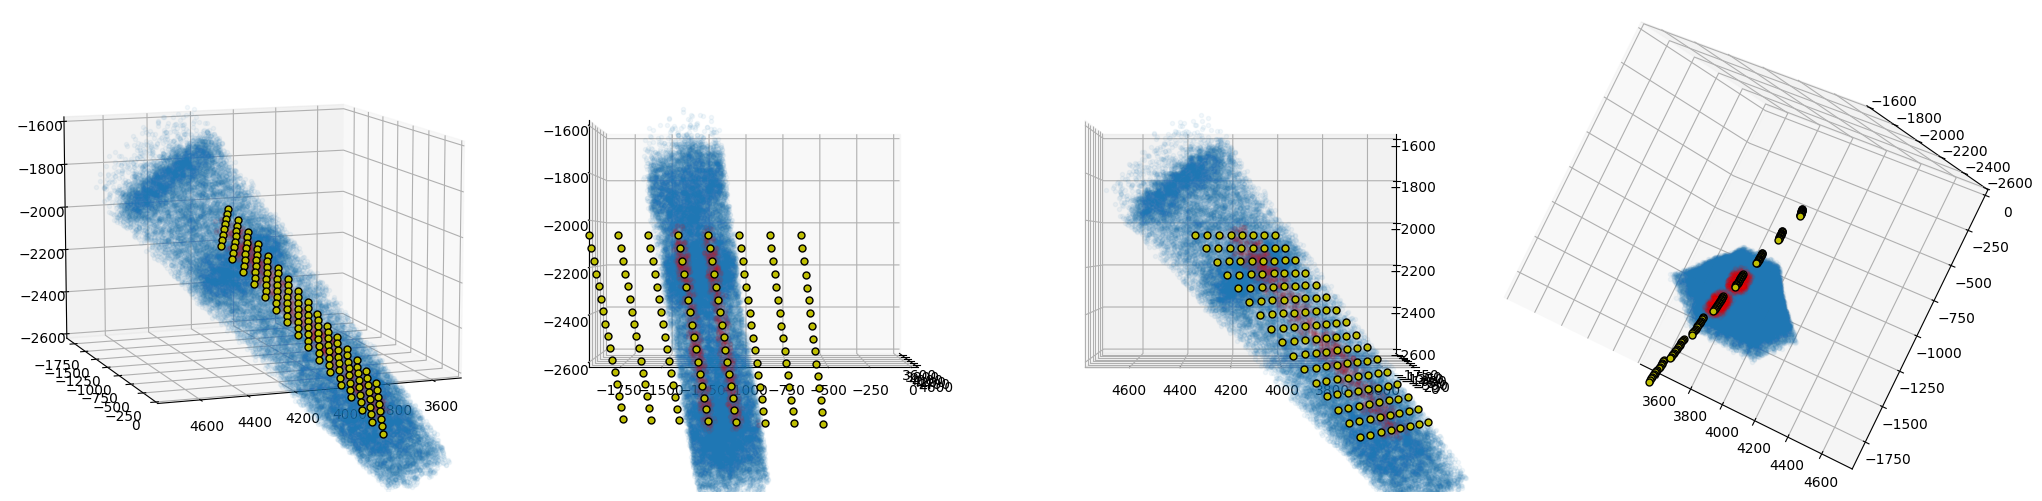

In [40]:
# check probe locations
cell_coords = simulation["circuit"].cells.positions()

# get microcircuit cell coords
microcircuit_cells = filter_microcircuit_cells(simulation)["gid"]
microcircuit_cells_coords = cell_coords.loc[microcircuit_cells]

# get target cell coords
target_cell_coords = cell_coords.loc[CELL_IDS]

# plot
fig = viz.plot_probe_with_circuit(cell_coord=microcircuit_cells_coords, target_cell_coord=target_cell_coords, probe_coord=channel_coord)

In [42]:
# calculate euclidean distance b/w cells and channel contacts
nearest_channel = []
for c_i, cell_i in enumerate(cell_true_coord.index):
    channel_dist = []
    for ch_i in range(channel_coord.shape[0]):
        channel_dist.append(scipy.spatial.distance.euclidean(cell_true_coord.iloc[c_i], channel_coord[ch_i, :]))
    nearest_channel.append(np.argmin(np.array(channel_dist)))
nearest_channel_series = pd.Series(data=nearest_channel, index=cell_true_coord.index)

Check an example cell and its nearest channel contact

78
cell 10250 (red) and its nearest contact channel (75, blue) among channels (gray)


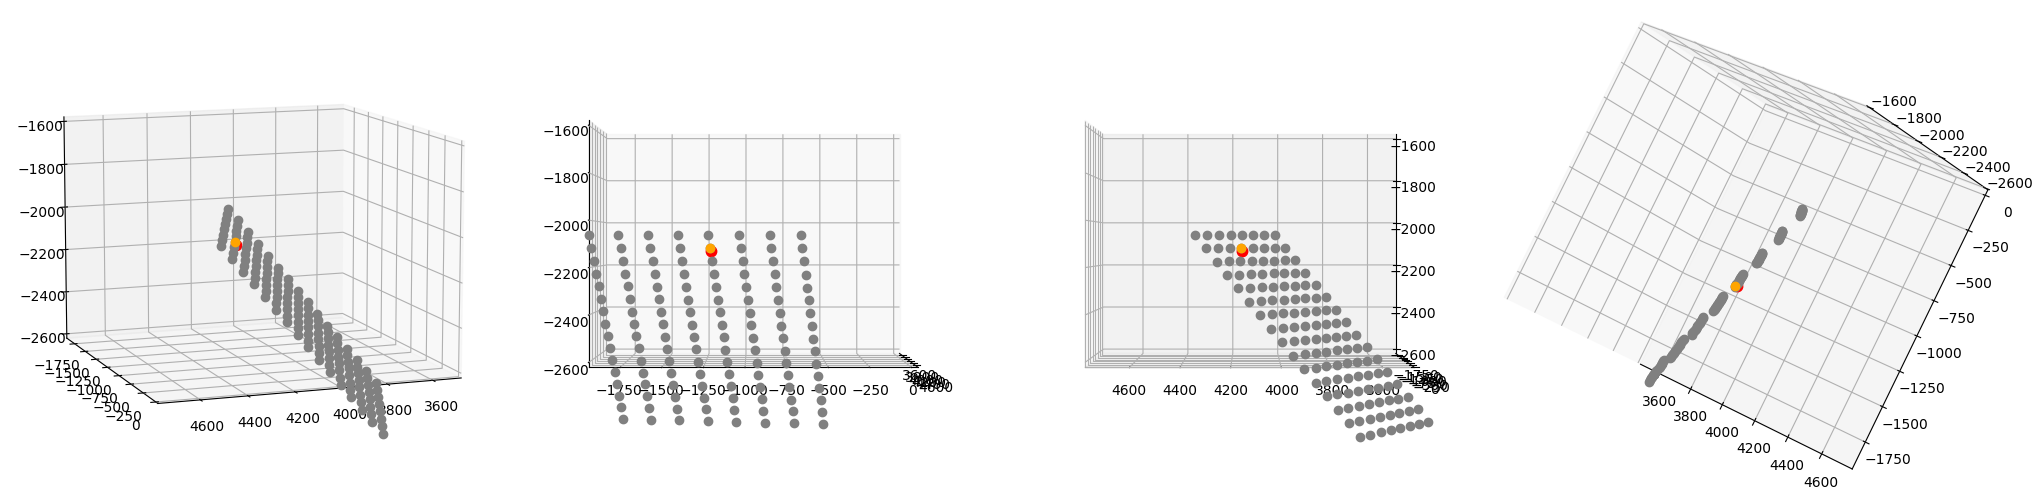

In [43]:
# Show example 
this_neuron = 10250
this_neuron_coord = cell_true_coord.loc[this_neuron]
cell_nearest_channel = nearest_channel_series.loc[this_neuron]
print(cell_nearest_channel)

# Quick check all coordinates
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(141, projection='3d')
ax.view_init(10, 70)
ax.plot(this_neuron_coord.x, this_neuron_coord.y, this_neuron_coord.z, marker=".", markersize=15,linestyle='None',color='red')
ax.plot(channel_coord[:,0], channel_coord[:,1], channel_coord[:,2], marker="o", linestyle='None', color='gray')
ax.plot(channel_coord[cell_nearest_channel,0], channel_coord[cell_nearest_channel,1], channel_coord[cell_nearest_channel,2], marker="o", linestyle='None', color='orange')
ax.set_xlim([3500, 4750]);
ax.set_zlim([-2600, -1600]);
ax.set_ylim([-1900, 0]);

ax = fig.add_subplot(142, projection='3d')
ax.view_init(0, 0)
ax.plot(this_neuron_coord.x, this_neuron_coord.y, this_neuron_coord.z, marker=".", markersize=15,linestyle='None',color='red')
ax.plot(channel_coord[:,0], channel_coord[:,1], channel_coord[:,2], marker="o", linestyle='None', color='gray')
ax.plot(channel_coord[cell_nearest_channel,0], channel_coord[cell_nearest_channel,1], channel_coord[cell_nearest_channel,2], marker="o", linestyle='None', color='orange')
ax.set_xlim([3500, 4750]);
ax.set_zlim([-2600, -1600]);
ax.set_ylim([-1900, 0]);

ax = fig.add_subplot(143, projection='3d')
ax.view_init(0, 90)
ax.plot(this_neuron_coord.x, this_neuron_coord.y, this_neuron_coord.z, marker=".", markersize=15,linestyle='None',color='red')
ax.plot(channel_coord[:,0], channel_coord[:,1], channel_coord[:,2], marker="o", linestyle='None', color='gray')
ax.plot(channel_coord[cell_nearest_channel,0], channel_coord[cell_nearest_channel,1], channel_coord[cell_nearest_channel,2], marker="o", linestyle='None', color='orange')
ax.set_xlim([3500, 4750]);
ax.set_zlim([-2600, -1600]);
ax.set_ylim([-1900, 0]);

ax = fig.add_subplot(144, projection='3d')
ax.view_init(50, -5, 60)
ax.plot(this_neuron_coord.x, this_neuron_coord.y, this_neuron_coord.z, marker=".",markersize=15, linestyle='None',color='red')
ax.plot(channel_coord[:,0], channel_coord[:,1], channel_coord[:,2], marker="o", linestyle='None', color='gray')
ax.plot(channel_coord[cell_nearest_channel,0], channel_coord[cell_nearest_channel,1], channel_coord[cell_nearest_channel,2], marker="o", linestyle='None', color='orange')
ax.set_xlim([3500, 4750]);
ax.set_zlim([-2600, -1600]);
ax.set_ylim([-1900, 0]);
plt.tight_layout()

print("cell 10250 (red) and its nearest contact channel (75, blue) among channels (gray)")

Label dataset with each cell's nearest channel

In [44]:
# takes 50 secs for 1000ish cells
nearest_channel = [] 
for cell_i in cell_labels:
    nearest_channel.append(nearest_channel_series.loc[cell_i])

10250
67
cell 587652 (red) and its nearest contact channel (64, blue) among channels (gray)


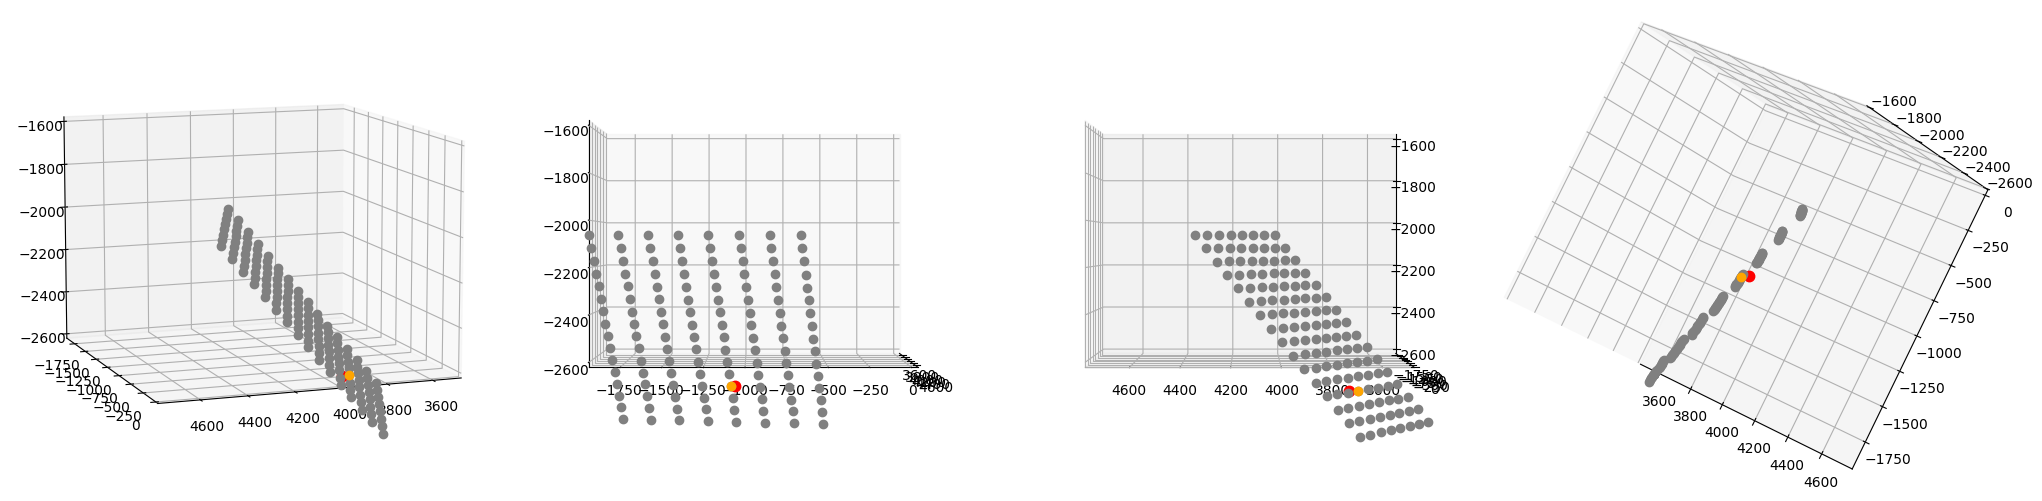

In [45]:
# Check another example 
ix = 50000
print(this_neuron)
this_neuron = cell_labels[ix]
this_neuron_coord = cell_true_coord.loc[this_neuron]
this_nearest_channel = nearest_channel[ix]
print(this_nearest_channel)

# Quick check all coordinates
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(141, projection='3d')
ax.view_init(10, 70)
ax.plot(this_neuron_coord.x, this_neuron_coord.y, this_neuron_coord.z, marker=".", markersize=15,linestyle='None',color='red')
ax.plot(channel_coord[:,0], channel_coord[:,1], channel_coord[:,2], marker="o", linestyle='None', color='gray')
ax.plot(channel_coord[this_nearest_channel,0], channel_coord[this_nearest_channel,1], channel_coord[this_nearest_channel,2], marker="o", linestyle='None', color='orange')
ax.set_xlim([3500, 4750]);
ax.set_zlim([-2600, -1600]);
ax.set_ylim([-1900, 0]);

ax = fig.add_subplot(142, projection='3d')
ax.view_init(0, 0)
ax.plot(this_neuron_coord.x, this_neuron_coord.y, this_neuron_coord.z, marker=".", markersize=15,linestyle='None',color='red')
ax.plot(channel_coord[:,0], channel_coord[:,1], channel_coord[:,2], marker="o", linestyle='None', color='gray')
ax.plot(channel_coord[this_nearest_channel,0], channel_coord[this_nearest_channel,1], channel_coord[this_nearest_channel,2], marker="o", linestyle='None', color='orange')
ax.set_xlim([3500, 4750]);
ax.set_zlim([-2600, -1600]);
ax.set_ylim([-1900, 0]);

ax = fig.add_subplot(143, projection='3d')
ax.view_init(0, 90)
ax.plot(this_neuron_coord.x, this_neuron_coord.y, this_neuron_coord.z, marker=".", markersize=15,linestyle='None',color='red')
ax.plot(channel_coord[:,0], channel_coord[:,1], channel_coord[:,2], marker="o", linestyle='None', color='gray')
ax.plot(channel_coord[this_nearest_channel,0], channel_coord[this_nearest_channel,1], channel_coord[this_nearest_channel,2], marker="o", linestyle='None', color='orange')
ax.set_xlim([3500, 4750]);
ax.set_zlim([-2600, -1600]);
ax.set_ylim([-1900, 0]);

ax = fig.add_subplot(144, projection='3d')
ax.view_init(50, -5, 60)
ax.plot(this_neuron_coord.x, this_neuron_coord.y, this_neuron_coord.z, marker=".",markersize=15, linestyle='None',color='red')
ax.plot(channel_coord[:,0], channel_coord[:,1], channel_coord[:,2], marker="o", linestyle='None', color='gray')
ax.plot(channel_coord[this_nearest_channel,0], channel_coord[this_nearest_channel,1], channel_coord[this_nearest_channel,2], marker="o", linestyle='None', color='orange')
ax.set_xlim([3500, 4750]);
ax.set_zlim([-2600, -1600]);
ax.set_ylim([-1900, 0]);
plt.tight_layout()

print("cell 587652 (red) and its nearest contact channel (64, blue) among channels (gray)")

# WRITE

In [46]:
# takes 12 secs for 1000ish cells, 128 channels
pd.DataFrame(instances).to_pickle(INSTANCE_FILE_PATH)
pd.DataFrame(channel_ids).to_pickle(CHANNEL_IDS_FILE_PATH)
pd.DataFrame(cell_labels).to_pickle(CELL_LABELS_FILE_PATH)
pd.DataFrame(spike_status).to_pickle(SPIKE_STATUS_FILE_PATH)
pd.DataFrame(nearest_channel).to_pickle(NEAREST_CHANNEL_FILE_PATH)